<h1>Stroke Prediction</h1>

Using a dataset containing patient attributes, I will attempt to model and predict the occurance of strokes in the patient. Initially, I will only be using the SVM polynomial kernel. Further itterations will make use of different approaches.  

This stroke prediction dataset contains 5110 observations with 12 attributes. As mentioned previously, one of these attributes will be our response variable, i.e., whether the patient suffered a stroke or not. The attributes contained have both categorical and numerical values. A full description of all variables can be seen below:
1.	ID (categorical): Unique identifier
2.	Gender (categorical): “Male”, “Female”, or “Other”
3.	Age (numerical): Age of the patient
4.	Hypertension (categorical): 0 if the patient does not have hypertension and 1 if the patient does
5.	Heart Disease (categorical): 0 if the patient does not have any heart diseases, 1 if the patient has a heart disease
6.	Ever Married (categorical): “Yes” or “No” 
7.	Work type (categorical): "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8.	Residence (categorical): “Urban” or “Rural”
9.	Average Glucose (numerical): Average glucose level in blood
10.	BMI (numerical): Patient body mass index
11.	Smoking (categorical): "formerly smoked", "never smoked", "smokes" or "Unknown"
12.	Stroke (categorical): Dummy variable, 0 if the patient never had a stroke, 1 if the patient has had a stroke. This will be our response variable.

One of the biggest challenges in this dataset is the heavy class imbalance (~1:20). This means that sampling approaches such as oversampling, undersampling and/or SMOTE will be required. This of considerable importance as we are dealing with a medical diagnosis situation and it is desirable to reduce the false negatives as much as possible.

See below the libraries required for this project.


In [1]:
library(data.table)
library(mltools)
library(e1071)
library(ggcorrplot)
library(MLmetrics)
library(caret)
library(kernlab)
library(themis)


Attaching package: 'e1071'


The following object is masked from 'package:mltools':

    skewness


Loading required package: ggplot2


Attaching package: 'MLmetrics'


The following object is masked from 'package:base':

    Recall


Loading required package: lattice


Attaching package: 'caret'


The following objects are masked from 'package:MLmetrics':

    MAE, RMSE



Attaching package: 'kernlab'


The following object is masked from 'package:ggplot2':

    alpha


Loading required package: recipes

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'recipes'


The following object is masked from 'package:stats':

    step



Attaching package: 'themis'


The following objects are masked from 

<h3>Data Cleaning</h3>

We will first load the dataset, examine its characteristics by calling the summary and str functions.

In [2]:
data <- read.csv("healthcare-dataset-stroke-data.csv")


In [3]:
head(data)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>
1,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
3,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
6,56669,Male,81,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1


In [4]:
summary(data)

       id           gender               age         hypertension    
 Min.   :   67   Length:5110        Min.   : 0.08   Min.   :0.00000  
 1st Qu.:17741   Class :character   1st Qu.:25.00   1st Qu.:0.00000  
 Median :36932   Mode  :character   Median :45.00   Median :0.00000  
 Mean   :36518                      Mean   :43.23   Mean   :0.09746  
 3rd Qu.:54682                      3rd Qu.:61.00   3rd Qu.:0.00000  
 Max.   :72940                      Max.   :82.00   Max.   :1.00000  
 heart_disease     ever_married        work_type         Residence_type    
 Min.   :0.00000   Length:5110        Length:5110        Length:5110       
 1st Qu.:0.00000   Class :character   Class :character   Class :character  
 Median :0.00000   Mode  :character   Mode  :character   Mode  :character  
 Mean   :0.05401                                                           
 3rd Qu.:0.00000                                                           
 Max.   :1.00000                                      

In [5]:
str(data)

'data.frame':	5110 obs. of  12 variables:
 $ id               : int  9046 51676 31112 60182 1665 56669 53882 10434 27419 60491 ...
 $ gender           : chr  "Male" "Female" "Male" "Female" ...
 $ age              : num  67 61 80 49 79 81 74 69 59 78 ...
 $ hypertension     : int  0 0 0 0 1 0 1 0 0 0 ...
 $ heart_disease    : int  1 0 1 0 0 0 1 0 0 0 ...
 $ ever_married     : chr  "Yes" "Yes" "Yes" "Yes" ...
 $ work_type        : chr  "Private" "Self-employed" "Private" "Private" ...
 $ Residence_type   : chr  "Urban" "Rural" "Rural" "Urban" ...
 $ avg_glucose_level: num  229 202 106 171 174 ...
 $ bmi              : chr  "36.6" "N/A" "32.5" "34.4" ...
 $ smoking_status   : chr  "formerly smoked" "never smoked" "never smoked" "smokes" ...
 $ stroke           : int  1 1 1 1 1 1 1 1 1 1 ...


In [6]:
str(data[data$bmi=="N/A",])

'data.frame':	201 obs. of  12 variables:
 $ id               : int  51676 27419 8213 25226 61843 69160 1845 37937 18587 15102 ...
 $ gender           : chr  "Female" "Female" "Male" "Male" ...
 $ age              : num  61 59 78 57 58 59 63 75 76 78 ...
 $ hypertension     : int  0 0 0 0 0 0 0 0 0 1 ...
 $ heart_disease    : int  0 0 1 1 0 0 0 1 0 0 ...
 $ ever_married     : chr  "Yes" "Yes" "Yes" "No" ...
 $ work_type        : chr  "Self-employed" "Private" "Private" "Govt_job" ...
 $ Residence_type   : chr  "Rural" "Rural" "Urban" "Urban" ...
 $ avg_glucose_level: num  202.2 76.2 219.8 217.1 189.8 ...
 $ bmi              : chr  "N/A" "N/A" "N/A" "N/A" ...
 $ smoking_status   : chr  "never smoked" "Unknown" "Unknown" "Unknown" ...
 $ stroke           : int  1 1 1 1 1 1 1 1 1 1 ...


In [7]:
str(data[data$smoking_status=="Unknown",])

'data.frame':	1544 obs. of  12 variables:
 $ id               : int  27419 60491 8213 25226 64778 61843 33879 47306 37937 18587 ...
 $ gender           : chr  "Female" "Female" "Male" "Male" ...
 $ age              : num  59 78 78 57 82 58 42 58 75 76 ...
 $ hypertension     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ heart_disease    : int  0 0 1 1 1 0 0 0 1 0 ...
 $ ever_married     : chr  "Yes" "Yes" "Yes" "No" ...
 $ work_type        : chr  "Private" "Private" "Private" "Govt_job" ...
 $ Residence_type   : chr  "Rural" "Urban" "Urban" "Urban" ...
 $ avg_glucose_level: num  76.2 58.6 219.8 217.1 208.3 ...
 $ bmi              : chr  "N/A" "24.2" "N/A" "N/A" ...
 $ smoking_status   : chr  "Unknown" "Unknown" "Unknown" "Unknown" ...
 $ stroke           : int  1 1 1 1 1 1 1 1 1 1 ...


I will removing the "id" attribute as it is just an identifier of the patient with no impact on their characteristics. I will then convert the class of the categorical attributes from character to factors, as to run One-Hot encodding later on.

Regarding smoking status, there are quite a few of "Unknown" values (1544), so for now I am going to be leaving them as it is, but further iterations may benefit from using approaches such as MissForest to make predictions for these attributes by taking into account the other attributes of these observations. 

In [8]:
data$id <- NULL #remove id attribute, as it doesnt provide info

#convert to factor variables that are strings as to run one-hot encoding
data$gender <- as.factor(data$gender)
data$ever_married <- as.factor(data$ever_married) 
data$work_type <- as.factor(data$work_type)
data$Residence_type <- as.factor(data$Residence_type)
data$smoking_status<- as.factor(data$smoking_status)

Some missing values are present in the BMI attribute. After converting the variable to numeric, and examining the skewedness of the BMI data, we will be replacing the missing values with either the mean or the median.

In [9]:
databmi <- data[data$bmi!="N/A",] #remove N/A from BMI observations
databmi$bmi<- as.numeric(databmi$bmi)

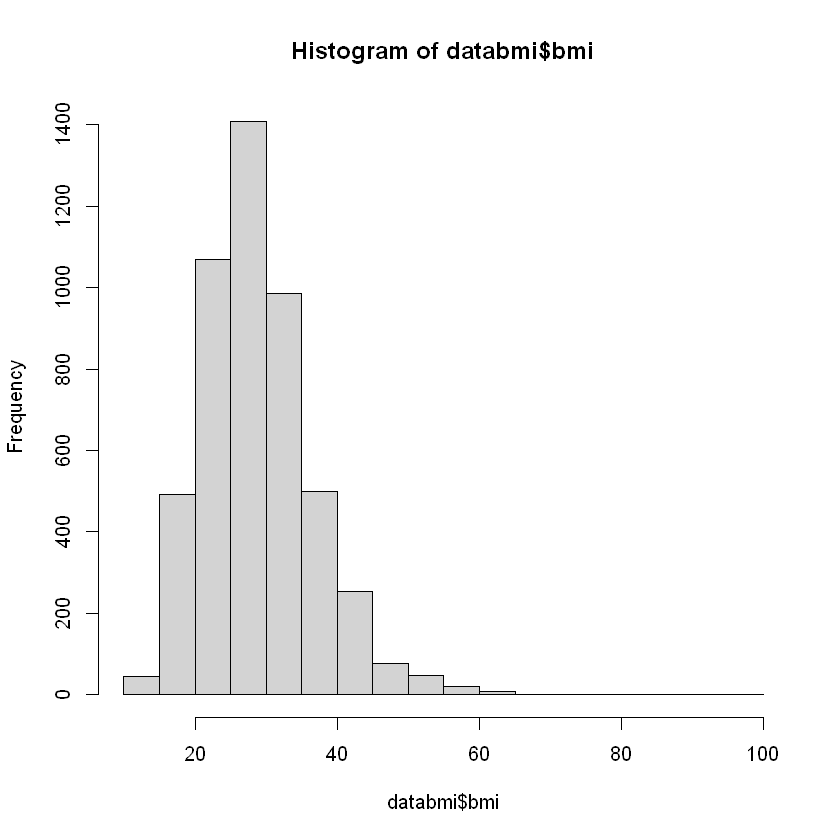

In [10]:
hist(databmi$bmi)

The BMI data looks skewed to the right, so I will be replacing the missing values with the median value.


In [11]:
medianbmi <- toString(median(databmi$bmi)) #converting to string the median value
data[data$bmi=="N/A",]$bmi <- medianbmi #replacing N/A values in data set with median value
data$bmi<- as.numeric(data$bmi) #convert bmi from str to numeric

Next, I will be running One Hot encoding for all the categorical values, which will put the data in a form that is able to be modeled later on using SVM

In [12]:
#Run one hot encoding for categorical variables
newdata <- one_hot(as.data.table(data)) 

#convert to data frame
data.df <- as.data.frame(newdata)


I want to look at the correlation of the different variables. Particularly, I want to see the correlation between the attributes
and the stroke class. Further down the line, I may select the variables that are most correlated and see what results are obtained and how they differ from not removing any of the attributes.


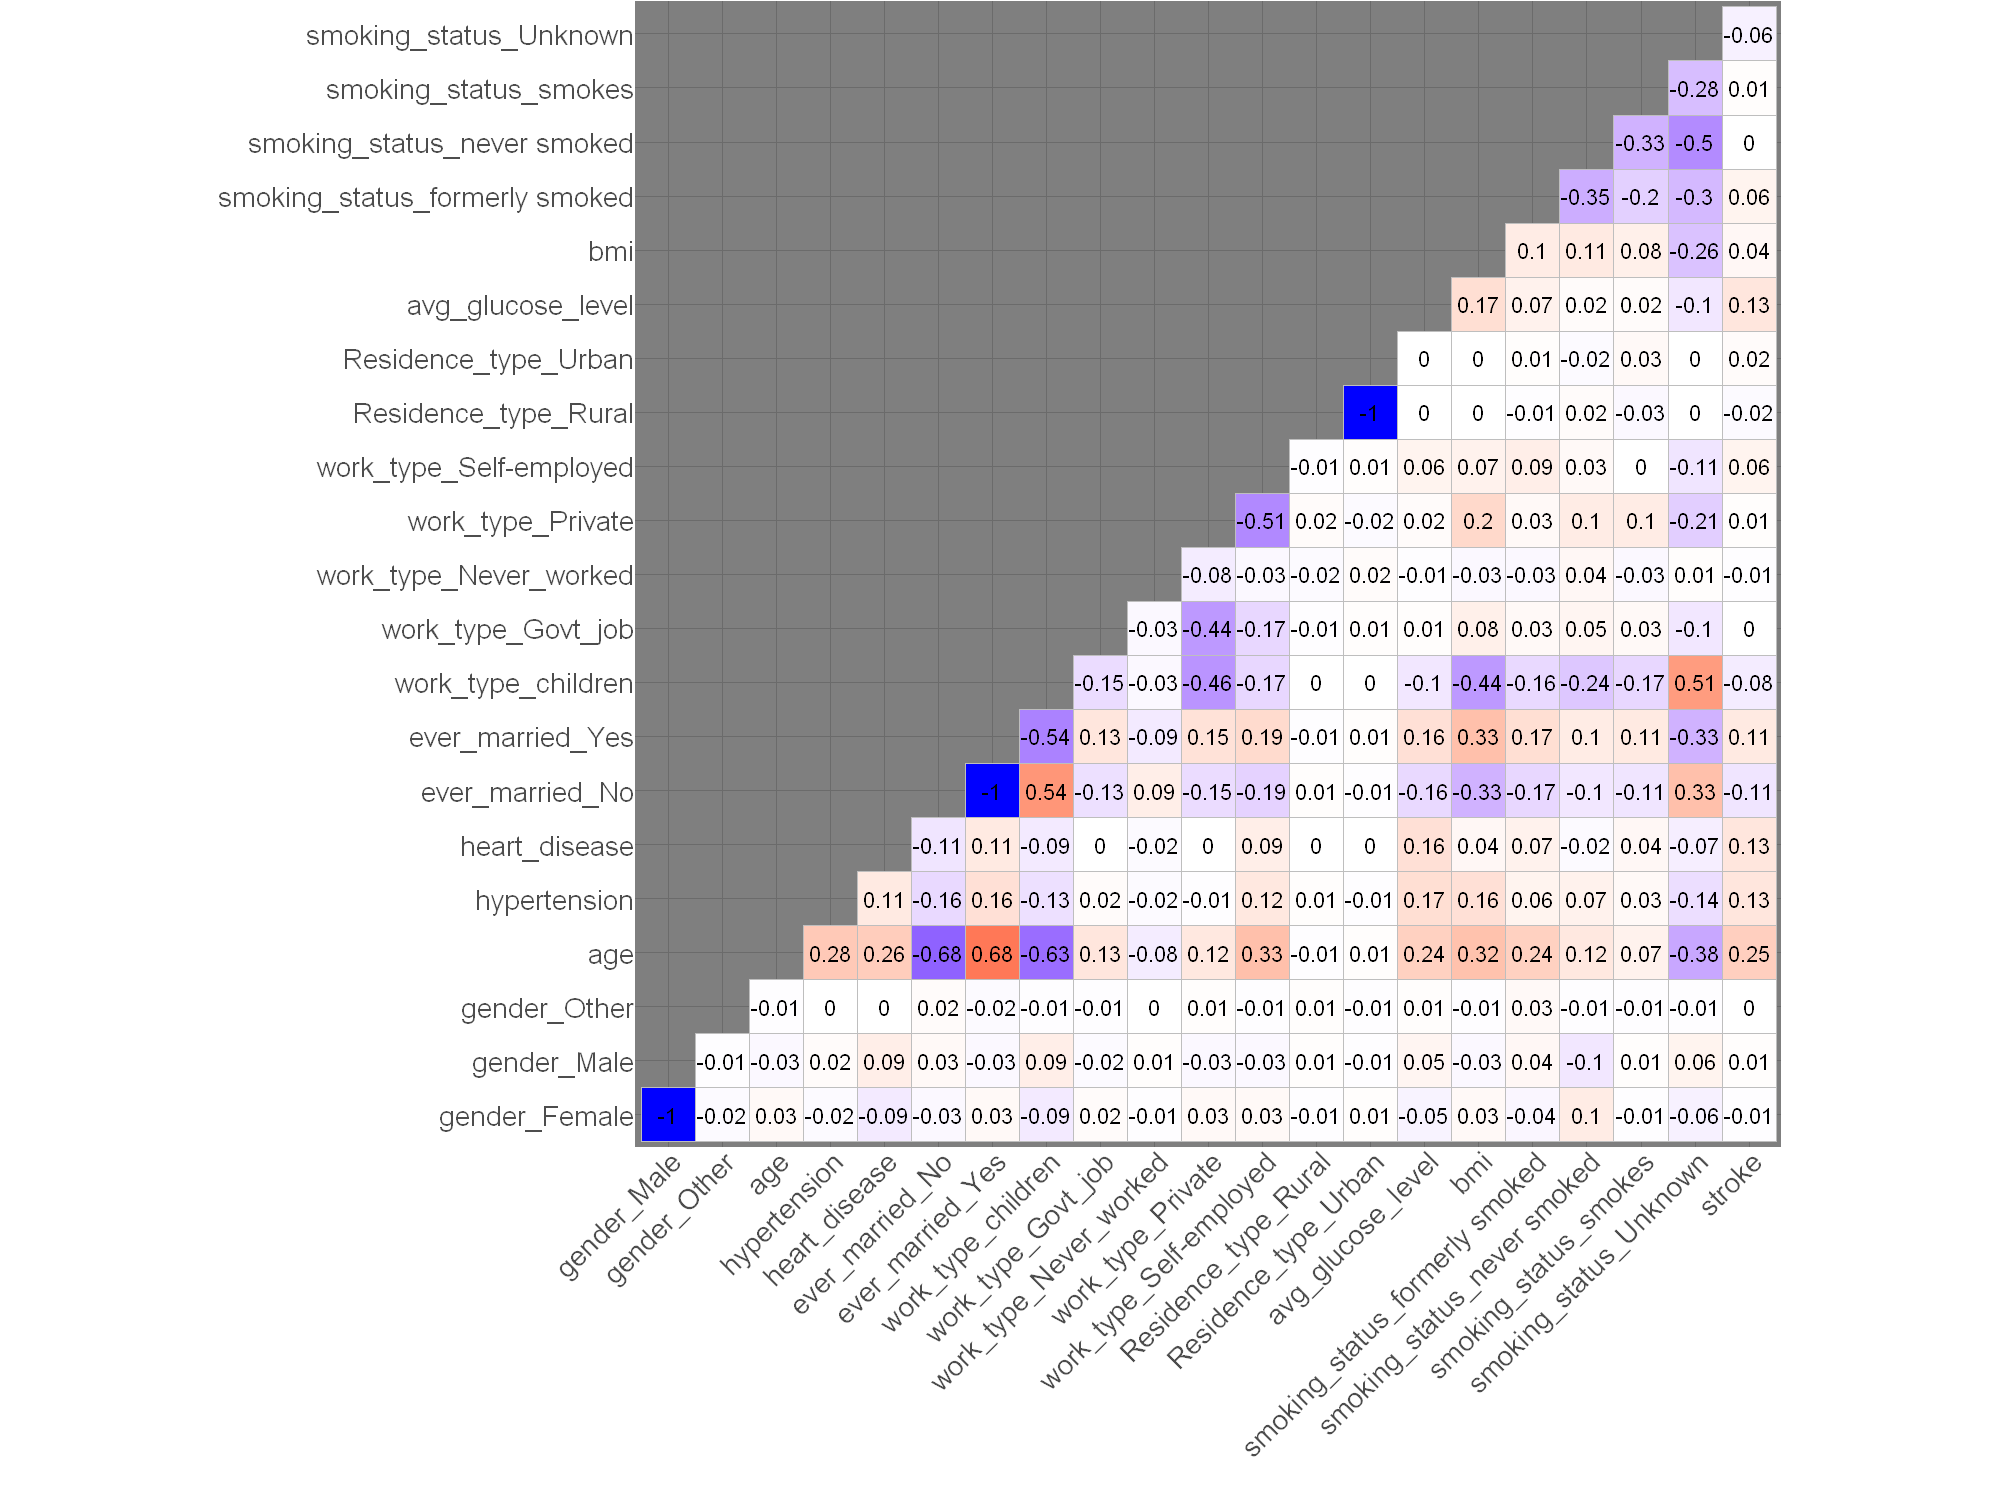

In [13]:
options(repr.plot.width = 100, repr.plot.height = 75, repr.plot.res = 20) #setting dimensions for the graph
ggcorrplot(cor(data.df),hc.order = FALSE, type = "lower",
  lab = TRUE, ggtheme = ggplot2::theme_dark(), lab_size = 28, tl.cex = 100, show.legend = FALSE)


<h3>Data Modeling</h3>

I will split the dataset into training and testing (80:20). I will also be scaling the data to ensure that the different magnitudes of the numerical attributes do not have an impact on the results.

In [14]:
RNGkind(sample.kind = "default")
set.seed(1)

n <- nrow(data.df)
col <- as.numeric(ncol(data.df))

train <- sample(1:n, round(n*.8)) 

data.df$stroke<- as.factor(data.df$stroke)

In [15]:
scal.df.train <- scale(data.df[train,c("age","bmi", "avg_glucose_level")])
scal.df.test <- scale(data.df[-train,c("age","bmi", "avg_glucose_level")],
                      center = attr(scal.df.train, "scaled:center"),
                      scale = attr(scal.df.train, "scaled:scale"))

In [16]:
data.df[train,c("age","bmi", "avg_glucose_level")] <- scal.df.train
data.df[-train,c("age","bmi", "avg_glucose_level")] <- scal.df.test

In [17]:
#saving the class variable for training and test as to compare later with the predictions of the model
y.train <- data.df[train,"stroke"] 
y.test <- data.df[-train,"stroke"]



In [18]:
#Definining training and testing data sets

data.df.train <- data.df[train,] 
data.df.test <- subset (data.df[-train,], select = -stroke)

The first fitting will be done using degree = 4, cost and gamma equal 1 to have a feel of where the results done. We will then conduct hyper parameter as well as some feature selection and compare the results to these initial results.

In [19]:
set.seed(1)

svmfitunb <- svm(stroke~.,data= data.df.train,
              kernel = "polynomial",
              degree = 4,
              cost = 1,
              gamma = 1,
              scale = FALSE)

svm.predtrain  <- predict(svmfitunb ,newdata = data.df.train)

table(true = y.train, pred = svm.predtrain)

svm.predtest  <- predict(svmfitunb ,newdata = data.df.test)

table(true = y.test, pred = svm.predtest)
print(mean(svm.predtest != y.test))

    pred
true    0    1
   0 3881    4
   1   44  159

    pred
true   0   1
   0 930  46
   1  34  12

[1] 0.07827789


While the totall error% in prediction is 7.8%, this metric is not of much value in this case. As expected, the heavy class imbalance leads our model to predict heavily towards the majority class, that is, we see a large number of false negatives (recall = .26). To address this, I will conduct sampling using SMOTE, followed by undersampling. 

In [20]:
set.seed(1)

smote_train <- smote(data.df.train, var = "stroke", over_ratio = .3) #used SMOTE, with a representation of 50% of the majority class observations

For the binary attributes, SMOTE does not identify a binary value. Since it calculates values that lie between neighbours, it will assign values between 0 and 1. I will round off these values so they represent more closely the original data.

In [21]:
cnames <- colnames(smote_train)
num <- c("age", "bmi", "avg_glucose_level", "stroke")

In [22]:
nonnum <- cnames[!(cnames %in% num)]

In [23]:
for (x in nonnum){
    smote_train[,x] <- round(smote_train[,x])
}


In [24]:
summary(smote_train$stroke)

0    1 
3885 1165

I will now perform undersampling by selecting a number of the majority class values (1650 out of 4861) and merging them with the original minority classes, plus those created by SMOTE. A key assumption here is that the order of the observations in the data is random. Further iterations of this project would require a random approach to selecting these values through the use of a function.

In [25]:
smote_nostroke <- smote_train[smote_train$stroke == 0, ] #extracted observations with no stroke
smotedown_train_pre <- smote_nostroke[c(1:1650),] #selected 1650 observations (undersampling size that gave best results)
smotedown_train <- rbind(smotedown_train_pre,smote_train[smote_train$stroke == 1, ]) #joined back together with stroke observations


In [26]:
summary(smotedown_train$stroke)

0    1 
1650 1165

After doing the sampling, I will proceed to fit the data, modeled using the SVM polynomial kernel. I will be making use of 10 fold cross validation, with a focus on improving the F1 score, which is closely related to the recall score. In terms of hyperparameter search, I will be using a random search approach. This has resulted in good results for me in the past and it is preferable when dealing with limited computing power.

In [27]:
set.seed(1)

ctrl <- trainControl(method = "cv",
                     number = 10, 
                     summaryFunction = prSummary, # TUNE ON F1 SCORE
                     verboseIter = T,
                     search = "random") #randomly tries hyperparameters, faster than giving a grid, gave better results


svmFit3 <- train(stroke~.,data=smotedown_train,
                 method = "svmPoly",
                 trControl = ctrl,
                 tuneLength = 10, #Number fo random parameter it will try on each fold
                 metric = "F", #fitting as to maximize F which in turn will seek to maximize recall
                scale = FALSE) 

svm.pred3 <- predict(svmFit3, newdata = data.df.test)

table(true = y.test, pred = svm.pred3)

print(mean(svm.pred3 != y.test))

+ Fold01: degree=3, scale=0.0438459, C= 27.38106 
- Fold01: degree=3, scale=0.0438459, C= 27.38106 
+ Fold01: degree=1, scale=0.0010868, C=  0.11529 
- Fold01: degree=1, scale=0.0010868, C=  0.11529 
+ Fold01: degree=2, scale=0.1204904, C=  0.50289 
- Fold01: degree=2, scale=0.1204904, C=  0.50289 
+ Fold01: degree=1, scale=0.0043483, C=  1.73113 
- Fold01: degree=1, scale=0.0043483, C=  1.73113 
+ Fold01: degree=3, scale=0.0636967, C=  0.03592 
- Fold01: degree=3, scale=0.0636967, C=  0.03592 
+ Fold01: degree=3, scale=1.8118572, C=  1.66534 
- Fold01: degree=3, scale=1.8118572, C=  1.66534 
+ Fold01: degree=2, scale=0.0010341, C=264.17730 
- Fold01: degree=2, scale=0.0010341, C=264.17730 
+ Fold01: degree=2, scale=0.1322088, C=  1.07567 
- Fold01: degree=2, scale=0.1322088, C=  1.07567 
+ Fold01: degree=3, scale=0.9013645, C=  4.69525 
- Fold01: degree=3, scale=0.9013645, C=  4.69525 
+ Fold01: degree=3, scale=0.0001332, C= 15.92794 
- Fold01: degree=3, scale=0.0001332, C= 15.92794 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


Aggregating results
Selecting tuning parameters
Fitting degree = 3, scale = 0.901, C = 4.7 on full training set


    pred
true   0   1
   0 826 150
   1  29  17

[1] 0.1751468


While the results have improved from those obtained without using sampling, there are still far from desirable. In this case, recall was .37 (a 42% improvement) and accurarcy was 82.5%. I will now proceed to remove attributes that do not show any correlation (measured previously) with the objective class and compare those results with the above.

In [28]:
newdata.df <- data.df[,c("age","bmi", "avg_glucose_level","smoking_status_formerly smoked", "work_type_Self-employed","work_type_children",
                           "ever_married_Yes", "ever_married_No","heart_disease", "hypertension", "stroke")]

col <- as.numeric(ncol(newdata.df))

In [29]:
data.df.train2 <- newdata.df 
data.df.test2 <- subset(newdata.df[-train,], select = -stroke )

In [74]:
set.seed(1)

smote_train <- smote(data.df.train2, var = "stroke", over_ratio = .3) #used SMOTE, with a representation of 30% of the majority class observations

In [75]:
cnames <- colnames(smote_train)
num <- c("age", "bmi", "avg_glucose_level", "stroke")
nonnum <- cnames[!(cnames %in% num)]

In [76]:
for (x in nonnum){
    smote_train[,x] <- round(smote_train[,x])
}

In [77]:
summary(smote_train$stroke)

0    1 
4861 1458

In this case, we will be increasing the majority class to 2000 in order to address the false positives.

In [78]:
smote_nostroke <- smote_train[smote_train$stroke == 0, ] #extracted observations with no stroke
smotedown_train_pre <- smote_nostroke[c(1:1650),] #selected 1650 observations (undersampling size that gave best results)
smotedown_train <- rbind(smotedown_train_pre,smote_train[smote_train$stroke == 1, ]) #joined back together with stroke observations


In [79]:
set.seed(1)

ctrl <- trainControl(method = "cv",
                     number = 10, 
                     summaryFunction = prSummary, # TUNE ON F1 SCORE
                     verboseIter = T,
                     #sampling = "down",
                     search = "random") #randomly tries hyperparameters, faster than giving a grid, gave better results


svmFit3 <- train(stroke~.,data=smotedown_train,
                 method = "svmPoly",
                 trControl = ctrl,
                 metric = "F",
                tuneLength = 3) #fitting as to maximize F which in turn will seek to maximize recall

svm.pred3 <- predict(svmFit3,newdata = data.df.test2)

table(true = y.test, pred = svm.pred3)

print(mean(svm.pred3 != y.test))

+ Fold01: degree=3, scale=0.57862, C=21.65624 
- Fold01: degree=3, scale=0.57862, C=21.65624 
+ Fold01: degree=1, scale=1.01801, C= 0.05941 
- Fold01: degree=1, scale=1.01801, C= 0.05941 
+ Fold01: degree=2, scale=0.03184, C= 0.26602 
- Fold01: degree=2, scale=0.03184, C= 0.26602 
+ Fold02: degree=3, scale=0.57862, C=21.65624 
- Fold02: degree=3, scale=0.57862, C=21.65624 
+ Fold02: degree=1, scale=1.01801, C= 0.05941 
- Fold02: degree=1, scale=1.01801, C= 0.05941 
+ Fold02: degree=2, scale=0.03184, C= 0.26602 
- Fold02: degree=2, scale=0.03184, C= 0.26602 
+ Fold03: degree=3, scale=0.57862, C=21.65624 
- Fold03: degree=3, scale=0.57862, C=21.65624 
+ Fold03: degree=1, scale=1.01801, C= 0.05941 
- Fold03: degree=1, scale=1.01801, C= 0.05941 
+ Fold03: degree=2, scale=0.03184, C= 0.26602 
- Fold03: degree=2, scale=0.03184, C= 0.26602 
+ Fold04: degree=3, scale=0.57862, C=21.65624 
- Fold04: degree=3, scale=0.57862, C=21.65624 
+ Fold04: degree=1, scale=1.01801, C= 0.05941 
- Fold04: deg

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


Aggregating results
Selecting tuning parameters
Fitting degree = 3, scale = 0.579, C = 21.7 on full training set


    pred
true   0   1
   0 812 164
   1  10  36

[1] 0.1702544


In this case we obtained a recall of .783 and an total %error of 17%. This is an improvement over the scores obtained using all the attributes, as focusing on only the attributes that showed some correlation with the objective class variable improved the recall score by 110%.

<h3>Conclusion</h3>

As expected, the biggest challenge in properly modeling the data provided was finding how to deal with the considerable class imbalance. Performing SMOTE, followed by undersampling improved the recall score by more than four times (.26 vs .37) Further feature selection, such as selecting the attributes that showed correlation with the objective class variable further improved the recall score to .78, while maintaining an total accuracy of .83. Further iterations would make use of different algorithms to fit the data in order to improve these scores. In terms of data cleaning/feature manipulation, there is a large number of patients that showed as smoking status: Unknown. Further itereations could attempt to predict these data points, such as through the use of MissForest, as having smoked is one of the features that showed correlation with suffering a stroke.